# 2024 COMP90042 Project
*Make sure you change the file name with your group id.*

# Readme

## Group: Wed5PM_Group1

| Name              | Student ID | Email                               |
| ----------------- | ---------- | ----------------------------------- |
| Xuan Wang         | 1329456    | xuanwang8@student.unimelb.edu.au    |
| Wei Zhao          | 1118649    | weizhao1@student.unimelb.edu.au     |
| Sunchuangyu Huang | 1118472    | sunchuangyuh@student.unimelb.edu.au |

## Overview

This notebook contains the essential functions required for task implementation. Training process is commented out for efficiency, as we provide a download link for the pretrained model. For current code, the only part you need to run mannually is the classifier training process, you have to run the code in given order, otherwise the code will not work properly.

## Usage

To use this notebook, simply run the required functions and uncomment the training blocks if you wish to run the training process. However, for optimal efficiency, please use the pretrained model provided.

## External Resources

- [Original Project GitHub Repository](https://github.com/drcarenhan/COMP90042_2024)
- [Wed5PM_Group1 Github Repository](https://github.com/rNLKJA/COMP90042-Natural-Language-Processing-Group-Project)
- [Canva Preliminary Study Presentation](https://www.canva.com/design/DAGFYYhpUhA/di_mKsvf_CiDBGGfOedx1w/edit)
- [Preliminary Study Presentation Recording](https://veed.io/view/0465503d-8ccb-463b-8800-0273907e5694)
- [Overleaf ACL Project Report](https://www.overleaf.com/read/sgchwdbmvjbq#c47aff)

# 1.DataSet Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [ ]:
## install project dependencies and load required libraries
!pip install contractions  # install contraction library
!pip install gdown

import requests
from pathlib import Path
import gdown
import hashlib

import contractions
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import pandas as pd
from pathlib import Path
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm
tqdm.pandas()
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
base_stopwords = set(stopwords.words('english'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 9.0 MB/s eta 0:00:00


The code block below is designed to download and verify the required datasets for a fact-checking project. It performs the following tasks:

1. **Define URLs and Expected MD5 Hashes**
2. **Check data Directory Existence**
3. **Download Functions**:
    - download_file: Downloads a file from a given URL to a specified destination if it does not already exist.
    - download_evidence: Specifically handles downloading the evidence file from Google Drive using gdown.
4. **Validation Function**:
    - check_md5: Computes and checks the MD5 hash of a file against the expected value to verify its integrity.
5. **Download and Verify Files through MD5**.

This ensures that all required datasets are downloaded only if necessary and are verified for integrity, avoiding redundant downloads and ensuring data correctness.

In [ ]:
## Download required datasets
# define URLs for each file
urls = {
    'train-claims.json': 'https://raw.githubusercontent.com/drcarenhan/COMP90042_2024/main/data/train-claims.json',
    'dev-claims.json': 'https://raw.githubusercontent.com/drcarenhan/COMP90042_2024/main/data/dev-claims.json',
    'dev-claims-baseline.json': 'https://raw.githubusercontent.com/drcarenhan/COMP90042_2024/main/data/dev-claims-baseline.json',
    'test-claims-unlabelled.json': 'https://raw.githubusercontent.com/drcarenhan/COMP90042_2024/main/data/test-claims-unlabelled.json',
    'evidence.json': 'https://drive.google.com/uc?id=1JlUzRufknsHzKzvrEjgw8D3n_IRpjzo6'
}

# expected md5 hash values
expected_md5s = {
    'train-claims.json': '671a07d1545a2dc467e870bc1e76961c',
    'dev-claims.json': '0076e390272dacfb27341f9190985c5c',
    'dev-claims-baseline.json': '5ca47229487d6cf7faa964f94e77777c',
    'test-claims-unlabelled.json': '8b5309187ac284963a5c6ec0ff467a3b',
    'evidence.json': '091fd62cccba1105fd8de5c38b541f91'
}

# define data folder path
data_folder = Path('data')
file_paths = {
    'train-claims.json': data_folder / 'train-claims.json',
    'dev-claims.json': data_folder / 'dev-claims.json',
    'dev-claims-baseline.json': data_folder / 'dev-claims-baseline.json',
    'test-claims-unlabelled.json': data_folder / 'test-claims-unlabelled.json',
    'evidence.json': data_folder / 'evidence.json'
}

# check directory existance
if not data_folder.exists():
    data_folder.mkdir(parents=True, exist_ok=True)

# define download function
def download_file(url: str, destination: Path):
    """Download a file if it doesn't already exist."""
    if destination.exists():
        print(f"File {destination} already exists. Skipping download.")
    else:
        print(f"Downloading {url} to {destination}.")
        response = requests.get(url)
        destination.write_bytes(response.content)
        print(f"Downloaded {destination}.")

def download_evidence(url: str, destination: Path):
    """Download the evidence file from Google Drive."""
    if destination.exists():
        print(f"File {destination} already exists. Skipping download.")
    else:
        print(f"Downloading evidence file from Google Drive to {destination}.")
        gdown.download(url, str(destination), quiet=False)
        print(f"Downloaded evidence file to {destination}.")

# define validation function
def check_md5(file_path: Path, expected_md5: str) -> bool:
    """Check the MD5 hash of a file."""
    if not file_path.exists():
        return False
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest() == expected_md5

# download files if they do not exist or if their MD5 hash does not match the expected value
for file_name, file_path in file_paths.items():
    print(file_name, file_path)
    if not check_md5(file_path, expected_md5s[file_name]):
        if file_name == 'evidence.json':
            url = urls[file_name]
            download_evidence(url,file_path)
        else:
            url = urls[file_name]
            download_file(url, file_path)
    else:
        print(f"File {file_path} is up-to-date with the correct MD5 hash.")

print("All required datasets are downloaded and verified.")

train-claims.json data/train-claims.json
Downloaded data/train-claims.json.
dev-claims.json data/dev-claims.json
Downloaded data/dev-claims.json.
dev-claims-baseline.json data/dev-claims-baseline.json
Downloaded data/dev-claims-baseline.json.
test-claims-unlabelled.json data/test-claims-unlabelled.json
Downloaded data/test-claims-unlabelled.json.
evidence.json data/evidence.json


Downloading...
From (original): https://drive.google.com/uc?id=1JlUzRufknsHzKzvrEjgw8D3n_IRpjzo6
From (redirected): https://drive.google.com/uc?id=1JlUzRufknsHzKzvrEjgw8D3n_IRpjzo6&confirm=t&uuid=8c658722-1f18-40fa-aaf2-4b2600cc358a
To: /content/data/evidence.json
100%|██████████| 174M/174M [00:00<00:00, 194MB/s]

Downloaded evidence file to data/evidence.json.
All required datasets are downloaded and verified.


This code block blow performs the following tasks:

1. **Data Loading and Processing:**
    - Loads JSON files containing claims and evidence data into Pandas DataFrames.
    - Processes the DataFrames by exploding the `evidences` column and merging the claims DataFrames with the evidence DataFrame.
2. **Corpus Generation and Storage:**
    - Generates a training corpus by concatenating claim text and evidence text from the merged DataFrame.
    - Saves the corpus to a pickle file named corpus.pkl in the specified data directory.
3. **MD5 Hash Validation:**
    - Checks if the corpus.pkl file exists in the data folder.
    - If the file exists, loads the corpus from the pickle file and validates its MD5 hash using the check_md5 function.
    - Utilizes an assert statement to ensure the integrity of the saved corpus by comparing the calculated MD5 hash with the expected value.
4. **Displaying Corpus Information:**
    - Displays the first 5 entries of the corpus and its total length.

This code block effectively processes the data, generates a training corpus, saves it to a pickle file, validates the MD5 hash for data integrity, and provides a summary of the corpus content.

In [ ]:
import pandas as pd
from pathlib import Path

# define the path to the data directory and md5 hash value
data_path = Path('data/')
expected_md5 = '97a5f314672108ba9a3e070ba9649a08'

def explode_evidences_from_a_df(df):
    if 'claim_id' not in df.columns:
        df.reset_index(inplace=True, names='claim_id')

    if 'evidences' not in df.columns:
        df.columns = ['claim_id', 'claim_text']
    else:
        df = df.explode('evidences')
        df.columns = ['claim_id', 'claim_text', 'claim_label', 'evidence_id']
    return df

def process_evidence_df(df):
    df.drop_duplicates(inplace=True)
    df.reset_index(inplace=True)
    df.columns = ['evidence_id', 'evidence_text']
    return df

# function to generate corpus
def generate_corpus():
    # load the JSON files into DataFrames
    dev_claims_baseline_df = pd.read_json(data_path / "dev-claims-baseline.json", orient='index')
    dev_claims_df = pd.read_json(data_path / 'dev-claims.json', orient='index')
    test_claims_unlabeled_df = pd.read_json(data_path / 'test-claims-unlabelled.json', orient='index')
    train_claims_df = pd.read_json(data_path / 'train-claims.json', orient='index')
    evidence_df = pd.read_json(data_path / 'evidence.json', orient='index')

    # explode the 'evidences' column in the claims DataFrames
    dev_claims_baseline_df = explode_evidences_from_a_df(dev_claims_baseline_df)
    dev_claims_df = explode_evidences_from_a_df(dev_claims_df)
    test_claims_unlabeled_df = explode_evidences_from_a_df(test_claims_unlabeled_df)
    train_claims_df = explode_evidences_from_a_df(train_claims_df)

    # process the evidence DataFrame
    evidence_df = process_evidence_df(evidence_df)

    #  erge the claims DataFrames with the evidence DataFrame
    dev_claims_baseline_df = pd.merge(dev_claims_baseline_df, evidence_df, on='evidence_id', how='left')
    dev_claims_df = pd.merge(dev_claims_df, evidence_df, on='evidence_id', how='left')
    train_claims_df = pd.merge(train_claims_df, evidence_df, on='evidence_id', how='left')

    # concatenate all DataFrames into a single DataFrame
    merged_df = pd.concat([dev_claims_baseline_df, dev_claims_df, train_claims_df, evidence_df], ignore_index=True)

    # fill NaN values with empty strings
    merged_df.fillna('', inplace=True)

    # generate the training corpus
    corpus = list(merged_df.apply(lambda df: df.claim_text + ' ' + df.evidence_text, axis=1))
    return corpus

# Define the path for the pickle file
corpus_pickle_path = data_path / 'corpus.pkl'

# Check if corpus.pkl exists in the data folder
if not corpus_pickle_path.exists():
    # corpus = generate_corpus()
    # with open(corpus_pickle_path, 'wb') as fi:
    #     pickle.dump(corpus, f)

    # Download the file from Google Drive
    url = 'https://drive.google.com/uc?id=1k1KjrNM1v0aM2kVhaRXuSAXUon90SSsb'
    gdown.download(url, str(corpus_pickle_path), quiet=False)

# Load the corpus from the pickle file
with open(corpus_pickle_path, 'rb') as f:
    corpus = pickle.load(f)
    print("Corpus loaded successfully.")


display(corpus[:5], len(corpus))

Corpus loaded successfully.


['[South Australia] has the most expensive electricity in the world. [citation needed] South Australia has the highest retail price for electricity in the country.',
 '[South Australia] has the most expensive electricity in the world. "South Australia has the highest power prices in the world".',
 '[South Australia] has the most expensive electricity in the world. The report encouraged the administration to curb acid rain emissions.',
 '[South Australia] has the most expensive electricity in the world. Myrna Kostash (born September 2, 1944) is a Canadian writer and journalist.',
 '[South Australia] has the most expensive electricity in the world. Category : Buildings and structures in the canton of Zürich']

1199358

The code block below performs the following tasks:

1. **Text Preprocessing and Tokenization:**

    - Defines a function `preprocess_and_tokenize` that preprocesses and tokenizes text data by expanding contractions, converting to lowercase, removing punctuation, tokenizing, and stemming tokens using the Porter Stemmer.

2. **Loading or Preprocessing Corpus:**

    - Checks if the preprocessed corpus pickle file exists.
    - If the file does not exist, it downloads the file from Google Drive using the direct download link.
    - Preprocesses the corpus data if required and saves it to the pickle file.

3. **Loading and Validating Corpus:**

    - Loads the preprocessed corpus from the pickle file.
    Validates the MD5 hash of the preprocessed corpus using the check_md5 function.
    - Displays the first 5 entries and the total length of the preprocessed corpus.

This code block effectively handles the preprocessing, loading, and validation of a preprocessed corpus, ensuring data integrity through MD5 hash validation.

In [ ]:
stemmer = PorterStemmer()

def preprocess_and_tokenize(text):
    try:
        # Expand contractions
        text = contractions.fix(text)
    except IndexError:
        # Handle cases where contractions.fix fails
        print(f"Error expanding contractions in text: {text}")

    # Convert text to lowercase
    text = text.lower()

    # Handle concatenated words with punctuation (e.g., "sentence.abc" -> "sentence abc")
    for char in string.punctuation:
        text = text.replace(char, ' ' + char + ' ')

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stopwords and stem tokens
    filtered_tokens = [stemmer.stem(word) for word in tokens if word not in base_stopwords and word.isalpha()]

    return filtered_tokens

preprocessed_corpus_pickle_path = data_path / 'preprocessed_corpus.pkl'

# load or preprocess the corpus
if not preprocessed_corpus_pickle_path.exists():
    # preprocessed_corpus = [' '.join(preprocess_and_tokenize(doc)) for doc in tqdm(corpus, desc="Preprocessing documents")]

    # with open(preprocessed_corpus_pickle_path, 'wb') as f:
    #     pickle.dump(preprocessed_corpus, f)
    url = 'https://drive.google.com/uc?id=17L10NGRXRm6WiThvSfadzYmGuqkVW0EE'
    gdown.download(url, str(preprocessed_corpus_pickle_path), quiet=False)

# load the corpus from the pickle file
with open(preprocessed_corpus_pickle_path, 'rb') as f:
    preprocessed_corpus = pickle.load(f)
    print("Corpus loaded successfully.")

display(preprocessed_corpus[:5], len(preprocessed_corpus))

Corpus loaded successfully.


['south australia ha the most expens electr in the world citat need south australia ha the highest retail price for electr in the countri',
 'south australia ha the most expens electr in the world south australia ha the highest power price in the world',
 'south australia ha the most expens electr in the world the report encourag the administr to curb acid rain emiss',
 'south australia ha the most expens electr in the world myrna kostash born septemb is a canadian writer and journalist',
 'south australia ha the most expens electr in the world categori build and structur in the canton of zürich']

1199358

In [ ]:
claim_text = "[South Australia] has the most expensive electricity in the world."
claim_tags = ' '.join(sorted(preprocess_and_tokenize(claim_text)))
print(claim_tags)

australia electr expens south world


# 2. Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

## TF-IDF Evidence Retrieval Approach

The quality of the retrieved evidence is crucial for the success of the claim classification task. If the evidence retrieved is of low quality or irrelevant, the subsequent claim classification will also be unreliable and inaccurate. Therefore, the focus of this approach is on the evidence retrieval component to ensure that the most relevant and informative evidence is provided for the claim classification.

**The key aspects of our approach are**:

1. Leveraging TF-IDF to extract relevant keywords from claims.
2. Training a targeted TF-IDF model for evidence retrieval using the extracted keywords.
3. Utilizing cosine similarity to identify the top 6 most relevant evidence texts for each claim.

This evidence retrieval process aims to provide the most relevant information to support the subsequent claim classification task.


1. **Initial TF-IDF Model Training:**

We will train a TF-IDF (Term Frequency-Inverse Document Frequency) model using the entire corpus of claims and evidence texts as a single collection This initial TF-IDF model will help us identify the most relevant keywords for each claim. We will use the TfidfVectorizer from the sklearn.feature_extraction.text module to train this TF-IDF model.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the TF-IDF vectorizer for tag extraction
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=preprocess_and_tokenize,  # define in previous block
    max_df=0.5,
    min_df=5,
    max_features=20000,
    ngram_range=(1, 3),
    use_idf=True,
    norm='l2'
)

# Define the file path for saving the TF-IDF vectorizer
tfidf_vec_1_file_path = data_path / 'tfidf_vectorizer.pkl'
expected_md5 = '055f9dbf117161b409cb47ca2dea19cb'

# Train and save the TF-IDF vectorizer if it doesn't exist
if not tfidf_vec_1_file_path.exists():
    # tfidf_vectorizer.fit(preprocessed_corpus)
    # with open(tfidf_vec_1_file_path, 'wb') as f:
    #     pickle.dump(tfidf_vectorizer, f)
    #     print("TF-IDF vectorizer saved to tfidf_vectorizer.pkl")
    url = "https://drive.google.com/uc?id=1CJHE3-lsc-IohfO5nWM64QBHkewXD-EV"
    gdown.download(url, str(tfidf_vec_1_file_path), quiet=False)

# load the corpus from the pickle file
with open(tfidf_vec_1_file_path, 'rb') as f:
    tfidf_vectorizer = pickle.load(f)
    print("Corpus loaded successfully.")

print("MD5 hash validation successful. The tfidf_vec_1 is saved correctly.")

Corpus loaded successfully.
MD5 hash validation successful. The tfidf_vec_1 is saved correctly.


2. **Keyword Extraction for Claims:**

For each claim, we will use the pre-trained TF-IDF model to extract the most relevant keywords.
We will preprocess the claim text, including steps like expanding contractions, converting to lowercase, and removing punctuation. Then, we will transform the preprocessed claim text into a TF-IDF vector using the fitted TF-IDF vectorizer. From the TF-IDF vector, we will identify the indices of the top N (e.g., 10) values, corresponding to the most important keywords. Finally, we will retrieve the feature names (keywords) associated with these top indices to represent the claim.


In [ ]:
def extract_most_relevant_keywords_for_a_claim(claim, tfidf_vectorizer, top_n=10):
    # Preprocess and tokenize the claim
    preprocessed_claim = preprocess_and_tokenize(claim)

    # Transform the preprocessed claim to a TF-IDF vector
    tfidf_vector = tfidf_vectorizer.transform([' '.join(preprocessed_claim)])

    # Convert the vector to an array for easier manipulation
    row_array = tfidf_vector.toarray()[0]

    # Get the indices of the top_n values
    top_n_idx = np.argsort(row_array)[-top_n:][::-1]

    # Get the corresponding feature names (keywords) for these indices
    feature_names = tfidf_vectorizer.get_feature_names_out()
    top_keywords = [feature_names[i] for i in top_n_idx if feature_names[i].isalpha()]

    return ' '.join(set(top_keywords))

# keywords extraction validation
claim = "When 3 per cent of total annual global emissions of carbon dioxide are from humans and Australia produces 1.3 per cent of this 3 per cent, then no amount of emissions reduction here will have any effect on global climate."

top_keywords = extract_most_relevant_keywords_for_a_claim(claim, tfidf_vectorizer)
print("Keyword extraction successful. Test claim has the following keywords: \n", top_keywords)

Keyword extraction successful. Test claim has the following keywords: 
 climat total produc human annual effect global australia per carbon


3. **Targeted TF-IDF Model for Evidence Retrieval:**

After extracting the keywords for each claim, we will train a second TF-IDF model specifically for evidence retrieval. This targeted TF-IDF model will be trained using the keywords as the query and the evidence texts as the corpus. The objective is to find the top 6 most relevant evidence texts for each claim based on the keywords. We will use the TfidfVectorizer again, but with different parameter settings (e.g., lower max_df and max_features) to focus on the most relevant keywords and evidence texts.



In [ ]:
# Shuffle dataframe for training future training purpose

# evidence_df = pd.read_json(data_path / 'evidence.json', orient='index')
# evidence_df.reset_index(inplace=True)
# evidence_df.columns = ['evidence_id', 'evidence_text']
# evidence_df = evidence_df.sample(frac=1, random_state=42)
# evidence_df.to_csv('data/evidence.csv', index=False)
# evidence_df = pd.read_csv('data/evidence.csv')
# display(evidence_df.head())

def process_and_save_partition(evidence_df, tfidf_vectorizer, notebook_id, num_of_notebooks, num_partitions):
    """
    Process a partition of the DataFrame and save the results to a CSV file.

    Parameters:
    - evidence_df: The DataFrame containing the evidence.
    - tfidf_vectorizer: A fitted TF-IDF vectorizer.
    - notebook_id: The ID of the notebook (e.g., 1, 2, 3, 4, 5).
    - num_of_notebooks: The total number of notebooks to process the data.
    - num_partitions: The number of smaller partitions to divide the chunk into.
    """
    total_rows = evidence_df.shape[0]
    rows_per_notebook = total_rows // num_of_notebooks
    start_idx = (notebook_id - 1) * rows_per_notebook
    end_idx = notebook_id * rows_per_notebook if notebook_id < num_of_notebooks else total_rows

    # Select the partition of the DataFrame to process
    partition_df = evidence_df.iloc[start_idx:end_idx].copy()

    # Calculate the size of each smaller partition
    partition_size = int(np.ceil(len(partition_df) / num_partitions))

    # Process each smaller partition
    for partition_id in tqdm(range(1, num_partitions + 1), desc=f"Notebook {notebook_id}"):
        partition_start = (partition_id - 1) * partition_size
        partition_end = min(partition_id * partition_size, len(partition_df))
        small_partition_df = partition_df.iloc[partition_start:partition_end].copy()

        # Apply the keyword extraction function
        small_partition_df['evidence_tags'] = small_partition_df['evidence_text'].apply(
            lambda x: extract_most_relevant_keywords_for_a_claim(x, tfidf_vectorizer)
        )

        # Save the processed partition to a CSV file
        output_path = f'data/evidence/{notebook_id}_{partition_id}_{partition_start + start_idx}-{partition_end + start_idx}.csv'
        small_partition_df.to_csv(output_path, index=False)

num_of_notebooks = 5   # Number of notebooks to process the data
notebook_id = 1        # Manually set this for each notebook
num_partitions = 100   # Number of smaller partitions within the notebook's chunk

# please run in different notebooks to complete this processing part
# process_and_save_partition(evidence_df, tfidf_vectorizer, notebook_id, num_of_notebooks, num_partitions)

In [ ]:
def load_processed_data(directory_path):
    """
    Load all processed CSV files from the specified directory into a single DataFrame.

    Parameters:
    - directory_path: The path to the directory containing the processed CSV files.

    Returns:
    - A single DataFrame containing all the processed data.
    """
    # Use pathlib to find all CSV files in the directory
    all_files = Path(directory_path).rglob('*.csv')

    # Initialize an empty list to store individual DataFrames
    df_list = []

    # Loop through each file and read it into a DataFrame
    for file in all_files:
        df = pd.read_csv(file)
        df_list.append(df)

    # Concatenate all DataFrames into a single DataFrame
    combined_df = pd.concat(df_list, ignore_index=True)

    return combined_df

# Directory containing the processed CSV files
# directory_path = 'data/evidence'

# Load all processed data into a single DataFrame
# processed_evidence_df = load_processed_data(directory_path)

# Save the combined DataFrame to a single CSV file
output_path = 'data/processed_evidence.csv'
# processed_evidence_df.to_csv(output_path, index=False)
# print(f"All processed data has been saved to {output_path}")

url = "https://drive.google.com/uc?id=1AfwVBx7eS1EFta1Y0be1-PShlDLG43m7"
gdown.download(url, str(output_path), quiet=False)

processed_evidence_df = pd.read_csv('data/processed_evidence.csv')
display(processed_evidence_df.head())

Downloading...
From (original): https://drive.google.com/uc?id=1AfwVBx7eS1EFta1Y0be1-PShlDLG43m7
From (redirected): https://drive.google.com/uc?id=1AfwVBx7eS1EFta1Y0be1-PShlDLG43m7&confirm=t&uuid=3da9d283-6a7b-44be-bf46-93ef4cfad471
To: /content/data/processed_evidence.csv
100%|██████████| 220M/220M [00:01<00:00, 188MB/s]


,evidence_id,evidence_text,evidence_tags
0,evidence-1067380,"Gilsum is a town in Cheshire County, New Hamps...",cheshir hampshir counti new unit state town
1,evidence-1176639,He was perhaps best known as the singer and co...,one vocal hit singer lead
2,evidence-971614,There were four sessions of the 35th General A...,session gener four assembl
3,evidence-791033,In response to the call by these scientists no...,coat scientist equiv hume summon columnist dvd...
4,evidence-73673,Muratori was born in Vendrana in the Budrio co...,commun born


In [ ]:
# 2nd tf-idf vectorizer based on evidence_tags
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=preprocess_and_tokenize,
    max_df=0.5, min_df=3,
    max_features=1000,
    ngram_range=(1, 1),
    use_idf=True,
    norm='l2',
)

tfidf_vec_2_file_path = data_path / 'tfidf_tag_vectorizer.pkl'

if not tfidf_vec_2_file_path.exists():
    # tfidf_vectorizer.fit(processed_evidence_df['evidence_tags'])
    # with open(tfidf_vec_2_file_path, 'wb') as f:
    #     pickle.dump(tfidf_vectorizer, f)
    # print("TF-IDF vectorizer saved to tfidf_vectorizer.pkl")
    url = "https://drive.google.com/uc?id=1NiqmcdnkWIouOeyAkeguX6XOxBt7S2IM"
    gdown.download(url, str(tfidf_vec_2_file_path), quiet=False)

# load the tfidf_tag_vectorizer from the pickle file
with open(tfidf_vec_2_file_path, 'rb') as f:
    vectorizer = pickle.load(f)
    print("tfidf_tag_vectorizer loaded successfully.")

tfidf_tag_vectorizer loaded successfully.


In [ ]:
# Load the evidence DataFrame
# directory_path = 'data/evidence'
# processed_evidence_df = load_processed_data(directory_path)
# processed_evidence_df = processed_evidence_df.dropna(subset=['evidence_tags'])
# evidence_tfidf = vectorizer.transform(processed_evidence_df['evidence_tags'])

# with open('data/evidence_tfidf.pkl', 'wb') as file:
#     pickle.dump(evidence_tfidf, file)

# print("evidence_tfidf object has been saved to evidence_tfidf.pkl")
url = 'https://drive.google.com/uc?id=1SkC2OgnVFi9JJg5_ZcUaAmtLacLEzVWW'
gdown.download(url, str('data/evidence_tfidf.pkl'), quiet=False)

# Load the evidence_tfidf object from the pickle file
with open('data/evidence_tfidf.pkl', 'rb') as file:
    evidence_tfidf = pickle.load(file)

print("evidence_tfidf object has been loaded from evidence_tfidf.pkl")

Downloading...
From: https://drive.google.com/uc?id=1SkC2OgnVFi9JJg5_ZcUaAmtLacLEzVWW
To: /content/data/evidence_tfidf.pkl
100%|██████████| 56.9M/56.9M [00:00<00:00, 68.5MB/s]

evidence_tfidf object has been loaded from evidence_tfidf.pkl


4. **Evidence Retrieval:**

For each claim, we will use the targeted TF-IDF model to calculate the cosine similarity between the claim's keywords and the evidence texts. We will sort the evidence texts based on their cosine similarity scores and select the top 6 most relevant ones. These top 6 evidence texts will be associated with the corresponding claim for the final output.

In [ ]:
processed_evidence_df = pd.read_csv('data/processed_evidence.csv').dropna(subset=['evidence_tags'])
display(processed_evidence_df.head(5))

,evidence_id,evidence_text,evidence_tags
0,evidence-1067380,"Gilsum is a town in Cheshire County, New Hamps...",cheshir hampshir counti new unit state town
1,evidence-1176639,He was perhaps best known as the singer and co...,one vocal hit singer lead
2,evidence-971614,There were four sessions of the 35th General A...,session gener four assembl
3,evidence-791033,In response to the call by these scientists no...,coat scientist equiv hume summon columnist dvd...
4,evidence-73673,Muratori was born in Vendrana in the Budrio co...,commun born


In [ ]:
def perform_kmeans_clustering(evidence_tfidf, n_clusters=5, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    cluster_labels = kmeans.fit_predict(evidence_tfidf)
    return cluster_labels

def compute_overlap_rate(claim_tags, evidence_tags):
    claim_words = set(claim_tags.split())
    evidence_words = set(evidence_tags.split())
    overlap = len(claim_words.intersection(evidence_words))
    return overlap / min(len(claim_words), len(evidence_words))

def find_max_overlap_word_count(claim_tags, evidence_tags):
    claim_words = set(claim_tags.split())
    evidence_words = set(evidence_tags.split())
    overlap = len(claim_words.intersection(evidence_words))
    return overlap

def find_top_evidence(claim_tags, evidence_tfidf, vectorizer, evidence_df, top_n=6):
    # Transform the claim tags into a TF-IDF vector
    claim_tfidf = vectorizer.transform([claim_tags])

    # Calculate cosine similarity within the selected cluster
    relevant_tfidf = evidence_tfidf
    similarities = cosine_similarity(claim_tfidf, relevant_tfidf).flatten()

    # Calculate overlap rate for each evidence in the relevant cluster
    overlap_rates = evidence_df['evidence_tags'].apply(lambda evidence_tags: compute_overlap_rate(claim_tags, evidence_tags))
    similarities_between_claim_and_evidence = cosine_similarity(claim_tfidf, evidence_tfidf).flatten()

    # Combine overlap rate and cosine similarity into a single score
    combined_scores = similarities + overlap_rates + similarities_between_claim_and_evidence

    # Assign combined scores back to the relevant evidence DataFrame
    evidence_df['similaritie'] = similarities
    evidence_df['overlap_rate'] = overlap_rates
    evidence_df['combined_score'] = combined_scores
    evidence_df['max_match'] = evidence_df['evidence_tags'].apply(lambda evidence_tags: find_max_overlap_word_count(claim_tags, evidence_tags))

    # Filter and sort evidence
    filtered_evidence = evidence_df.query("similaritie > 0.55 and overlap_rate > 0.5 and combined_score > 1.5")
    if filtered_evidence.empty:
        print("No evidence met the filtering criteria. Returning the best available evidence.")
        # Return the top N evidence based on the highest combined score
        relevant_evidence = evidence_df.sort_values(by="combined_score", ascending=False).head(top_n)
    else:
        relevant_evidence = filtered_evidence.sort_values(by=["overlap_rate", "similaritie"], ascending=[False, False])
        relevant_evidence = relevant_evidence.sort_values(by="combined_score", ascending=False)

        # Check if relevant_evidence is empty before calling max
        if relevant_evidence.empty:
            print("No relevant evidence found after sorting. Returning the best available evidence.")
            relevant_evidence = evidence_df.sort_values(by="combined_score", ascending=False).head(top_n)
        else:
            max_match_value = max(relevant_evidence['max_match'])
            relevant_evidence = relevant_evidence[relevant_evidence.max_match == max_match_value].head(top_n)

    return list(relevant_evidence['evidence_id'])

In [ ]:
# testing code block
claim_text = "[South Australia] has the most expensive electricity in the world."
claim_tags = ' '.join(sorted(preprocess_and_tokenize(claim_text)))
print(f"claim_tags: {claim_tags}")

claim_tags: australia electr expens south world


In [ ]:
with open('/content/data/tfidf_tag_vectorizer.pkl', 'rb') as file:
    vectorizer = pickle.load(file)

with open('/content/data/evidence_tfidf.pkl', 'rb') as file:
    evidence_tfidf = pickle.load(file)

find_top_evidence(claim_tags, evidence_tfidf, vectorizer, processed_evidence_df, top_n=6)  # we can find 67732 and 572512 in the retrieved list

['evidence-949564', 'evidence-67732', 'evidence-572512', 'evidence-808896']

Test on provided `dev-claims.json` file, generate results and stored as a csv.

In [ ]:
# DO NOT RUN THIS CELL UNLESS YOU WANT TO SEE OUTPUT

# claim_dev_df = pd.read_json(data_path / 'dev-claims.json', orient='index')
# claim_dev_df.drop(['claim_label', 'evidences'], axis=1, inplace=True)  # drop irrelevant data regards to testing

# # find top evidences to the current text
# claim_dev_df['evidences'] = claim_dev_df.progress_apply(lambda df:  find_top_evidence(df.claim_text, evidence_tfidf, vectorizer, processed_evidence_df, top_n=6), axis=1)
# display(claim_dev_df.head())

# # store dev claims as dev_predictions
# claim_dev_df.T.to_json('data/dev_predictions.json')

Find top evidences for training set and prepare for future work

In [ ]:
# DO NOT RUN THIS CELL UNLESS YOU WANT TO SEE TRAINING PROCESS
# OTHERWISE USE THE CODE BLOCK BELOW TO DOWNLOAD THE PREPROCESSED DATA

# test_claims_df = pd.read_json(data_path / 'test-claims-unlabelled.json', orient='index')
# test_claims_df['evidences'] = test_claims_df.progress_apply(lambda df:  find_top_evidence(df.claim_text, evidence_tfidf, vectorizer, processed_evidence_df, top_n=6), axis=1)
# display(test_claims_df.head())
# test_claims_df.T.to_json('data/preprocessed_test_claims.json')

In [ ]:
url = "https://drive.google.com/uc?id=1-56hkNbSB_2Y44cO3MJzOT8dE6TOg3EQ"
gdown.download(url, 'data/preprocessed_test_claims.json', quiet=False)

test_claims_df = pd.read_json('data/preprocessed_test_claims.json', orient='index')
test_claims_df.head()

Downloading...
From: https://drive.google.com/uc?id=1-56hkNbSB_2Y44cO3MJzOT8dE6TOg3EQ
To: /content/data/preprocessed_test_claims.json
100%|██████████| 41.6k/41.6k [00:00<00:00, 53.1MB/s]


,claim_text,evidences
claim-1001,‘This study goes beyond statistical correlatio...,"[evidence-1202193, evidence-801489, evidence-1..."
claim-1003,"A recent study in Nature Geoscience, for insta...","[evidence-1039553, evidence-488743, evidence-7..."
claim-1009,‘Arctic ice conditions have been tracking at r...,"[evidence-1081596, evidence-18861, evidence-10..."
claim-1020,“The global reef crisis does not necessarily m...,"[evidence-901052, evidence-689266, evidence-98..."
claim-1028,A second coat of paint has much less of an eff...,"[evidence-180997, evidence-805036, evidence-24..."


## Prepare for Model Training

In this section, we prepared the claims dataset loader by first loading the claim and evidence data from JSON files into Pandas DataFrames. We then combined the claims and their corresponding evidence texts into a single DataFrame, ensuring that both the claim text and evidence text were tokenized and properly formatted. A custom tokenizer class was implemented to handle the tokenization and encoding of the text sequences. We built a vocabulary from the training data to map words to unique indices.

In [ ]:
# Function to load JSON files into DataFrames
def load_json_to_dataframe(file_path):
    df = pd.read_json(file_path, orient='index').reset_index()
    return df

# File paths
evidence_file = data_path / 'evidence.json'
train_claims_file = data_path / 'train-claims.json'
dev_claims_file = data_path / 'dev-claims.json'

# Load data into DataFrames
evidence_df = load_json_to_dataframe(evidence_file)
train_claims_df = load_json_to_dataframe(train_claims_file)
dev_claims_df = load_json_to_dataframe(dev_claims_file)

# Function to combine claims and evidence data
def combine_claims_evidence(claims_df, evidence_df, label_mapping):
    # Create a dictionary from the evidence DataFrame
    evidence_dict = evidence_df.set_index('index')[0].to_dict()

    print('Number of claims:', len(claims_df))

    data = []
    for _, row in tqdm(claims_df.iterrows(), total=len(claims_df)):
        claim_texts = preprocess_and_tokenize(row['claim_text'])
        claim_text = ' '.join(claim_texts)
        claim_label = label_mapping[row['claim_label']]

        # Retrieve and preprocess evidence texts
        evidence_texts = [preprocess_and_tokenize(evidence_dict[evidence_id]) for evidence_id in row['evidences']]
        evidence_text = ' '.join([' '.join(evidence) for evidence in evidence_texts])
        data.append({
            'claim_text': claim_text,
            'claim_label': claim_label,
            'evidence_text': evidence_text
        })
    return pd.DataFrame(data)

# Define label mapping
label_mapping = {
    "SUPPORTS": 0,
    "REFUTES": 1,
    "NOT_ENOUGH_INFO": 2,
    "DISPUTED": 3
}

# Combine train and dev data with evidence
train_data = combine_claims_evidence(train_claims_df, evidence_df, label_mapping)
dev_data = combine_claims_evidence(dev_claims_df, evidence_df, label_mapping)

Number of claims: 1228


  0%|          | 0/1228 [00:00<?, ?it/s]

Number of claims: 154


  0%|          | 0/154 [00:00<?, ?it/s]

The code below provides a PyTorch-based framework for processing text data, specifically for claim verification tasks. It includes:

- **CustomTokenizer Class**: A tokenizer that converts text into token IDs using a custom vocabulary, handling special tokens for classification ([CLS]), separation ([SEP]), and padding ([PAD]).
- **ClaimsDataset Class**: A custom dataset class that prepares claim and evidence text pairs for model training and evaluation. It uses the tokenizer to encode the text into input IDs and handles labels if not in test mode.
- **`create_data_loader` Function**: A utility function that creates PyTorch DataLoaders from the dataset, allowing for easy batching and loading of data during training and evaluation.
- **build_vocab Function**: A function to build a vocabulary from the training data by extracting unique tokens from the claim and evidence texts.

The code ensures efficient text preprocessing and data handling, facilitating the training of models on textual claim verification tasks.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
from torch.utils.data import Dataset, DataLoader

# CustomTokenizer Class
class CustomTokenizer:
    def __init__(self, vocab):
        self.vocab = vocab
        self.cls_token = "[CLS]"
        self.sep_token = "[SEP]"
        self.pad_token = "[PAD]"
        self.cls_token_id = self.vocab[self.cls_token]
        self.sep_token_id = self.vocab[self.sep_token]
        self.pad_token_id = self.vocab[self.pad_token]

    def tokenize(self, text):
        tokens = text.split()
        token_ids = [self.vocab.get(token, self.vocab['<unk>']) for token in tokens]
        return token_ids

    def encode(self, text, max_length, padding='max_length', truncation=True):
        tokens = [self.cls_token] + text.split() + [self.sep_token]
        token_ids = [self.vocab.get(token, self.vocab['<unk>']) for token in tokens]

        if truncation and len(token_ids) > max_length:
            token_ids = token_ids[:max_length-1] + [self.sep_token_id]

        if padding == 'max_length':
            padding_length = max_length - len(token_ids)
            token_ids += ([self.pad_token_id] * padding_length)

        return {
            'input_ids': torch.tensor(token_ids, dtype=torch.long),
        }

# ClaimsDataset Class
class ClaimsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, is_test=False):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_test = is_test

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        claim_text = str(self.data.iloc[index]['claim_text'])
        evidence_text = str(self.data.iloc[index]['evidence_text'])
        label = int(self.data.iloc[index]['claim_label']) if not self.is_test else -1

        # Combine claim and evidence text
        combined_text = claim_text + " " + evidence_text
        encoding = self.tokenizer.encode(
            combined_text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True
        )

        item = {
            'input_ids': encoding['input_ids'],
            'claim_text': claim_text,
            'evidence_text': evidence_text
        }

        if not self.is_test:
            item['label'] = torch.tensor(label, dtype=torch.long)

        return item

# Create Data Loader Function
def create_data_loader(df, tokenizer, max_len, batch_size, num_workers=0, is_test=False):
    datasets = ClaimsDataset(
        dataframe=df,
        tokenizer=tokenizer,
        max_len=max_len,
        is_test=is_test
    )
    return DataLoader(
        datasets,
        batch_size=batch_size,
        num_workers=num_workers
    )

# Function to build vocabulary from training data
def build_vocab(data):
    vocab = {'<unk>': 0, '[CLS]': 1, '[SEP]': 2, '[PAD]': 3}
    for _, row in data.iterrows():
        tokens = (row['claim_text'] + " " + row['evidence_text']).split()
        for token in tokens:
            if token not in vocab:
                vocab[token] = len(vocab)
    return vocab

# Build vocabulary from training data
vocab = build_vocab(train_data)

# Instantiate Tokenizer
tokenizer = CustomTokenizer(vocab)

# Create DataLoaders
train_data_loader = create_data_loader(train_data, tokenizer, max_len=128, batch_size=16, is_test=False)
dev_data_loader = create_data_loader(dev_data, tokenizer, max_len=128, batch_size=16, is_test=False)

## Transformer Classification Model

We define and set up the Transformer-based classification model. The PositionalEncoding class is implemented to add positional information to the input embeddings.

This code block defines a `Transformer-based `model for sequence classification using PyTorch. It consists of a `PositionalEncoding` class to add positional information to input embeddings and a `TransformerModel` class that includes an embedding layer, positional encoding, Transformer encoder layers, and a fully connected output layer. The model is initialized with specific hyperparameters and configured to use the `CrossEntropyLoss` function and Adam optimizer. The model, loss function, and optimizer are moved to the appropriate device (GPU or CPU) for training.

In [ ]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

# Transformer Model for Classification
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_encoder_layers, num_classes, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, model_dim)
        self.pos_encoder = PositionalEncoding(model_dim)
        encoder_layer = nn.TransformerEncoderLayer(model_dim, num_heads, dim_feedforward=512, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_encoder_layers)
        self.fc_out = nn.Linear(model_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask=None):
        src = self.embedding(src) * math.sqrt(src.size(1))
        src = self.dropout(self.pos_encoder(src))
        output = self.transformer_encoder(src, src_key_padding_mask=src_mask)
        output = self.fc_out(output.mean(dim=1))
        return output

# Model parameters
input_dim = len(vocab)  # Size of vocabulary
model_dim = 256  # Embedding dimension
num_heads = 8
num_encoder_layers = 6
num_decoder_layers = 6
num_classes = len(label_mapping)
dropout = 0.1

model = TransformerModel(input_dim, model_dim, num_heads, num_encoder_layers, num_classes, dropout)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")
model = model.to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Using device: cpu


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


## LSTM Classification Model

We define and set up the LSTM-based classification model with `pytorch.nn`.

The code block below defines and initializes an LSTM (Long Short-Term Memory) model for a sequence classification task using PyTorch. Here’s a breakdown of the components:

### LSTM Model Class:

- The `LSTM` class inherits from nn.Module and defines an LSTM-based neural network.
- The `__init__` method initializes the model with the following layers:
    - An embedding layer (`nn.Embedding`) that converts input tokens into dense vectors.
    - An LSTM layer (`nn.LSTM`) with multiple layers, which processes the input sequences.
    - A fully connected output layer (nn.Linear) that maps the LSTM outputs to the desired number of classes.
    - A dropout layer (`nn.Dropout`) to prevent overfitting.
- The `forward` method defines the forward pass of the model, where the input sequences are passed through the embedding layer, LSTM layer, dropout layer, and finally the fully connected layer. The last hidden state of the LSTM is used for classification.

### Model Initialization:

- The model is instantiated with specific hyperparameters: `input_dim` (size of the vocabulary), `model_dim` (embedding dimension), `num_layers` (number of LSTM layers), `num_classes` (number of output classes), and `dropout` (dropout rate).
- The model is moved to the specified device (e.g., GPU or CPU).

### Loss Function and Optimizer:

- The loss function is defined as `CrossEntropyLoss`, which is suitable for multi-class classification tasks.
- The optimizer is defined as Adam, which is an adaptive learning rate optimization algorithm, with a learning rate of `1e-4`.

This setup prepares the LSTM model for training on a sequence classification task, such as text classification or sentiment analysis.


In [ ]:
# LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_dim, model_dim, num_layers, num_classes, dropout=0.1):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(input_dim, model_dim)
        self.lstm = nn.LSTM(model_dim, model_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc_out = nn.Linear(model_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x, (hn, cn) = self.lstm(x)
        x = self.dropout(x)
        x = self.fc_out(x[:, -1, :])  # Use the last hidden state
        return x


input_dim_lstm = len(vocab)  # Size of vocabulary
model_dim_lstm = 256  # Embedding dimension
num_layers_lstm = 4
num_classes_lstm = len(label_mapping)
dropout_lstm = 0.1

lstm_model = LSTM(input_dim_lstm, model_dim_lstm, num_layers_lstm, num_classes_lstm, dropout_lstm)

lstm_model = lstm_model.to(device)
lstm_loss_fn = nn.CrossEntropyLoss().to(device)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=1e-4)

# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

## Training and Evaluating the Transformer and LSTM models

We define the functions required for training and evaluating the models.

The code block below defines three functions to train and evaluate a neural network model, specifically designed for sequence classification tasks using PyTorch. Here's a detailed description:

### Function to Train the Model for One Epoch:

`train_epoch(model, data_loader, loss_fn, optimizer, device)`: This function trains the model for one epoch.

- The model is set to training mode using `model.train()`.
- It iterates over batches of data from the `data_loader`.
- For each batch, it performs the following steps:
    - Moves the input data (`input_ids`) and labels to the specified device (e.g., GPU or CPU).
    - Passes the input data through the model to get the outputs.
    - Computes the loss using the loss function (`loss_fn`).
    - Computes predictions by taking the index of the maximum logit value.
    - Accumulates the number of correct predictions and the loss.
    - Performs backpropagation (`loss.backward()`), updates the model parameters (`optimizer.step()`), and resets the gradients (`optimizer.zero_grad()`).
- Returns the average loss and accuracy for the epoch.

### Function to Evaluate the Model on the Validation Set:

`eval_model(model, data_loader, criterion, device)`: This function evaluates the model on the validation set.
- The model is set to evaluation mode using `model.eval()`.
It iterates over batches of data from the `data_loader` without updating the model parameters.
- For each batch, it performs the following steps:
    - Moves the input data (`input_ids`) and labels to the specified device.
    - Passes the input data through the model to get the outputs.
    - Computes the loss using the criterion.
    - Computes predictions and accumulates the number of correct predictions and the loss.
- Returns the average loss and accuracy for the validation set.

### Function to Train the Model Over Multiple Epochs:

`train_model(model, train_data_loader, val_data_loader, loss_fn, optimizer, device, epochs, model_name='model')`: This function trains the model over multiple epochs and evaluates it on the validation set after each epoch.
- Initializes a dictionary `history` to store training and validation losses and accuracies.
- Tracks the best validation accuracy to save the best model state.
- For each epoch, it performs the following steps:
    - Calls `train_epoch` to train the model for one epoch and prints the training loss and accuracy.
    - Calls `eval_model` to evaluate the model on the validation set and prints the validation loss and accuracy.
    - Saves the training and validation metrics in the history dictionary.
    - If the validation accuracy improves, saves the model state to a file.
- Returns the `history` dictionary containing the training and validation metrics over all epochs.

These functions collectively manage the training process, including model training, evaluation, and saving the best model state based on validation accuracy.

In [ ]:
# Function to train the model for one epoch
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model.train()
    losses = []
    correct_predictions = 0
    for batch in data_loader:

        input_ids = batch["input_ids"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return np.mean(losses), correct_predictions.double() / len(data_loader.dataset)

# Function to evaluate the model on the validation set (dev-cliams)
def eval_model(model, data_loader, criterion, device):
    model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids)
            loss = criterion(outputs, labels)

            losses.append(loss.item())
            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels)

    return np.mean(losses), correct_predictions.double() / len(data_loader.dataset)

# Function to train the model over multiple epochs
def train_model(model, train_data_loader, val_data_loader, loss_fn, optimizer, device, epochs, model_name='model'):
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }
    best_accuracy = 0
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        print('-' * 10)

        train_loss, train_acc = train_epoch(
            model,
            train_data_loader,
            loss_fn,
            optimizer,
            device,
        )

        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_loss, val_acc, = eval_model(
            model,
            val_data_loader,
            loss_fn,
            device,
        )

        print(f'Val   loss {val_loss} accuracy {val_acc}')
        print()

        # Save metrics
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc.item())
        history["val_acc"].append(val_acc.item())

        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_'+model_name+'_state.bin')
            best_accuracy = val_acc

    return history

In [ ]:
# Train the Transformer model
transformer_history = train_model(model, train_data_loader, dev_data_loader, loss_fn, optimizer, device, epochs=10, model_name='transformer')

Epoch 1/10
----------
Train loss 1.144185142857688 accuracy 0.5162866449511401
Val   loss 1.0987181544303894 accuracy 0.551948051948052

Epoch 2/10
----------
Train loss 1.0753302790901877 accuracy 0.5504885993485342
Val   loss 1.0810352206230163 accuracy 0.564935064935065

Epoch 3/10
----------
Train loss 1.055177477273074 accuracy 0.5667752442996743
Val   loss 1.0777960479259492 accuracy 0.5714285714285714

Epoch 4/10
----------
Train loss 1.0323113234012158 accuracy 0.5757328990228013
Val   loss 1.0796044766902924 accuracy 0.577922077922078

Epoch 5/10
----------
Train loss 1.007130459531561 accuracy 0.5895765472312704
Val   loss 1.075583851337433 accuracy 0.564935064935065

Epoch 6/10
----------
Train loss 0.9789628881912726 accuracy 0.6042345276872965
Val   loss 1.0392242252826691 accuracy 0.5974025974025974

Epoch 7/10
----------
Train loss 0.9513109078654995 accuracy 0.6172638436482085
Val   loss 1.0821525990962981 accuracy 0.564935064935065

Epoch 8/10
----------
Train loss 0.9

In [ ]:
# Train the LSTM model
lstm_history = train_model(lstm_model, train_data_loader, dev_data_loader, lstm_loss_fn, lstm_optimizer, device, epochs=10, model_name='lstm')

Epoch 1/10
----------
Train loss 1.29223089481329 accuracy 0.4161237785016287
Val   loss 1.271548295021057 accuracy 0.44155844155844154

Epoch 2/10
----------
Train loss 1.2611353528964055 accuracy 0.4218241042345277
Val   loss 1.2693943619728087 accuracy 0.44155844155844154

Epoch 3/10
----------
Train loss 1.2591555575271705 accuracy 0.4250814332247557
Val   loss 1.2682156562805176 accuracy 0.44805194805194803

Epoch 4/10
----------
Train loss 1.2557164608658133 accuracy 0.43322475570032576
Val   loss 1.2617734670639038 accuracy 0.4675324675324675

Epoch 5/10
----------
Train loss 1.2496037390324977 accuracy 0.4519543973941368
Val   loss 1.2512583971023559 accuracy 0.4675324675324675

Epoch 6/10
----------
Train loss 1.2208872700666453 accuracy 0.46498371335504884
Val   loss 1.20130615234375 accuracy 0.512987012987013

Epoch 7/10
----------
Train loss 1.123958887991967 accuracy 0.5439739413680782
Val   loss 1.0935198545455933 accuracy 0.577922077922078

Epoch 8/10
----------
Train lo

## Plot Results from Model Training Process

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history1, history2, model1_name='Transformer', model2_name='LSTM'):
    epochs = range(1, len(history1['train_loss']) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history1['train_loss'], 'b', label=f'{model1_name} Train Loss')
    plt.plot(epochs, history1['val_loss'], 'r', label=f'{model1_name} Val Loss')
    plt.plot(epochs, history2['train_loss'], 'g', label=f'{model2_name} Train Loss')
    plt.plot(epochs, history2['val_loss'], 'orange', label=f'{model2_name} Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history1['train_acc'], 'b', label=f'{model1_name} Train Acc')
    plt.plot(epochs, history1['val_acc'], 'r', label=f'{model1_name} Val Acc')
    plt.plot(epochs, history2['train_acc'], 'g', label=f'{model2_name} Train Acc')
    plt.plot(epochs, history2['val_acc'], 'orange', label=f'{model2_name} Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

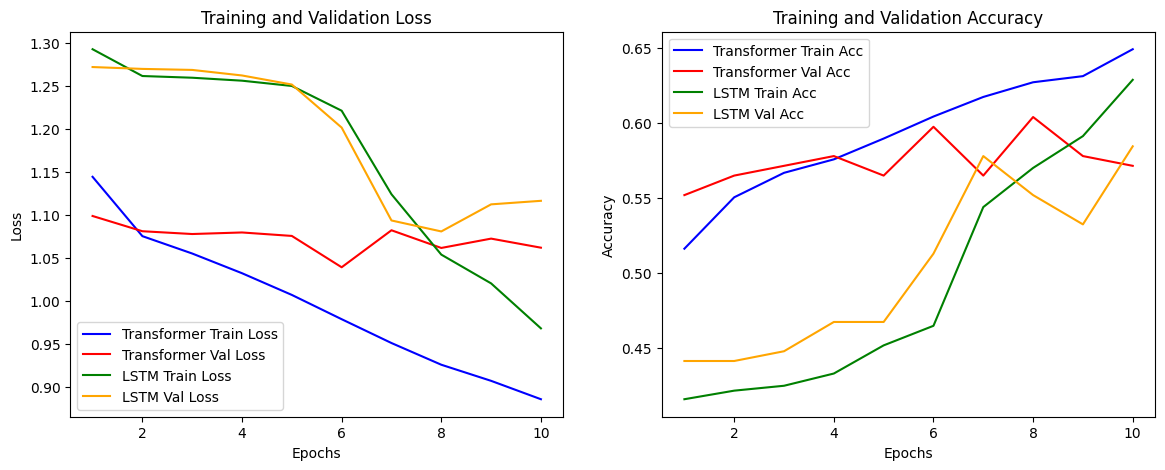

In [ ]:
plot_history(transformer_history, lstm_history)

As shown in figures, the Transformer
model outperformed the LSTM model in both
training and validation accuracy. The Transformer
model achieved a validation accuracy of 57.14%,
whereas the LSTM model achieved a lower val-
idation accuracy at 46.75%. For both Training
loss and validation loss, the transformer model
is much lower than LSTM. These results may
come from that the Transformer’s ability to capture
long-range dependencies and contextual relation-
ships through its self-attention mechanism, which
is particularly beneficial for understanding com-
plex claim-evidence relationships even with a very
small training dataset.

## Generate Result for Claims Fact-Checking

In [ ]:
dev_claims_df
evidence_df
test_claims_df

,claim_text,evidences
claim-1001,‘This study goes beyond statistical correlatio...,"[evidence-1202193, evidence-801489, evidence-1..."
claim-1003,"A recent study in Nature Geoscience, for insta...","[evidence-1039553, evidence-488743, evidence-7..."
claim-1009,‘Arctic ice conditions have been tracking at r...,"[evidence-1081596, evidence-18861, evidence-10..."
claim-1020,“The global reef crisis does not necessarily m...,"[evidence-901052, evidence-689266, evidence-98..."
claim-1028,A second coat of paint has much less of an eff...,"[evidence-180997, evidence-805036, evidence-24..."
...,...,...
claim-910,"The cement, iron and steel, and petroleum refi...","[evidence-823025, evidence-419945, evidence-19..."
claim-942,"‘We could be decades too fast, or decades too ...","[evidence-1010540, evidence-412934, evidence-6..."
claim-952,The Alaskan tundra is warming so quickly it ha...,"[evidence-566222, evidence-781678, evidence-64..."
claim-972,“Arctic land stores about twice as much carbon...,"[evidence-22100, evidence-519157, evidence-642..."


In [ ]:
# prediction of dev-claims.json
import json

dev_claims_df = pd.read_json(data_path / 'dev-claims.json', orient='index')
dev_claims_df['evidences'] = dev_claims_df.progress_apply(lambda df:  find_top_evidence(df.claim_text, evidence_tfidf, vectorizer, processed_evidence_df, top_n=6), axis=1)
display(dev_claims_df.head())
dev_claims_df.T.to_json('data/preprocessed_dev_claims.json')

# Define reverse label mapping
reverse_label_mapping = {v: k for k, v in label_mapping.items()}


# Function to combine claims and evidence for testing
def combine_claims_evidence_test(claims_df, evidence_df):
    evidence_dict = evidence_df.set_index('index')[0].to_dict()

    data = []
    for _, row in tqdm(claims_df.iterrows(), total=len(claims_df)):

        cliam_id = row.name
        claim_texts = preprocess_and_tokenize(row['claim_text'])
        claim_text = ' '.join(claim_texts)
        # Retrieve and preprocess evidence texts
        evidence_texts = [preprocess_and_tokenize(evidence_dict[evidence_id]) for evidence_id in row['evidences']]
        evidence_text = ' '.join([' '.join(evidence) for evidence in evidence_texts])
        data.append({
            'claim_id': cliam_id,
            'claim_text': claim_text,
            'evidence_text': evidence_text
        })
    return pd.DataFrame(data)

# Combine claims and evidence for the test set
# test_data = combine_claims_evidence_test(test_claims_df, evidence_df)
dev_claims_df = pd.read_json(data_path / 'preprocessed_dev_claims.json', orient='index')
test_data = combine_claims_evidence_test(dev_claims_df, evidence_df)


# Create DataLoader for the test data
test_data_loader = create_data_loader(test_data, tokenizer, max_len=128, batch_size=16, is_test=True)


# Function to make predictions
def predict(model, data_loader, device):
    model = model.eval()
    predictions = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)

            outputs = model(input_ids)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.cpu().numpy())

    return predictions

# Load the best model weights
model.load_state_dict(torch.load('best_transformer_state.bin'))

# Make predictions on the dev data
test_predictions = predict(model, test_data_loader, device)

# Save predictions to DataFrame
test_data['predictions'] = test_predictions


# Map numerical predictions back to label strings
test_data['predicted_label'] = test_data['predictions'].map(reverse_label_mapping)

# Create JSON structure similar to original dev_claims.json
result_json = {}
for _, row in test_data.iterrows():
    claim_id = row['claim_id']
    result_json[claim_id] = {
        'claim_text': dev_claims_df.loc[dev_claims_df.index == claim_id, 'claim_text'].values[0],
        'claim_label': row['predicted_label'],
        'evidences': dev_claims_df.loc[dev_claims_df.index == claim_id, 'evidences'].values[0]
    }

# Save to JSON file
with open('final_predictions.json', 'w') as f:
    json.dump(result_json, f, indent=4)

  0%|          | 0/154 [00:00<?, ?it/s]

No evidence met the filtering criteria. Returning the best available evidence.
No evidence met the filtering criteria. Returning the best available evidence.
No evidence met the filtering criteria. Returning the best available evidence.
No evidence met the filtering criteria. Returning the best available evidence.
No evidence met the filtering criteria. Returning the best available evidence.
No evidence met the filtering criteria. Returning the best available evidence.
No evidence met the filtering criteria. Returning the best available evidence.
No evidence met the filtering criteria. Returning the best available evidence.
No evidence met the filtering criteria. Returning the best available evidence.
No evidence met the filtering criteria. Returning the best available evidence.
No evidence met the filtering criteria. Returning the best available evidence.
No evidence met the filtering criteria. Returning the best available evidence.
No evidence met the filtering criteria. Returning th

,claim_text,claim_label,evidences
claim-752,[South Australia] has the most expensive elect...,SUPPORTS,"[evidence-966925, evidence-717829, evidence-70..."
claim-375,when 3 per cent of total annual global emissio...,NOT_ENOUGH_INFO,[evidence-1207394]
claim-1266,This means that the world is now 1C warmer tha...,SUPPORTS,"[evidence-694262, evidence-691855, evidence-11..."
claim-871,"“As it happens, Zika may also be a good model ...",NOT_ENOUGH_INFO,[evidence-133336]
claim-2164,Greenland has only lost a tiny fraction of its...,REFUTES,"[evidence-706218, evidence-1184008, evidence-3..."


  0%|          | 0/154 [00:00<?, ?it/s]

The reason that shows a bunrch of "No evidence met the filtering criteria. Returning the best available evidence." is we set a criteria for the evidence retrieve "similaritie > 0.55 and overlap_rate > 0.5 and combined_score > 1.5", which considers in cosine_similarity, overlap_rate, and their combination. The criteria might be kind of strict for the result of evidence retrieve. Therefore, we will keep the top evidence evaluated by "combined_score", incase there is no relevant evidence.



In [ ]:
# prediction of test-claims-unlabelled.json

# Combine claims and evidence for the test set
test_data = combine_claims_evidence_test(test_claims_df, evidence_df)

# Create DataLoader for the test data
test_data_loader = create_data_loader(test_data, tokenizer, max_len=128, batch_size=16, is_test=True)

# Define reverse label mapping
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Load the best model weights
model.load_state_dict(torch.load('best_transformer_state.bin'))

# Make predictions on the dev data
test_predictions = predict(model, test_data_loader, device)

# Save predictions to DataFrame
test_data['predictions'] = test_predictions


# Map numerical predictions back to label strings
test_data['predicted_label'] = test_data['predictions'].map(reverse_label_mapping)

# Create JSON structure similar to original dev_claims.json
result_json = {}
for _, row in test_data.iterrows():
    claim_id = row['claim_id']
    result_json[claim_id] = {
        'claim_text': test_claims_df.loc[test_claims_df.index == claim_id, 'claim_text'].values[0],
        'claim_label': row['predicted_label'],
        'evidences': test_claims_df.loc[test_claims_df.index == claim_id, 'evidences'].values[0]
    }

# Save to JSON file
with open('final_predictions_test_claims.json', 'w') as f:
    json.dump(result_json, f, indent=4)

  0%|          | 0/153 [00:00<?, ?it/s]

In [ ]:
# download the evaluation script

import requests
url = 'https://raw.githubusercontent.com/drcarenhan/COMP90042_2024/main/eval.py'
response = requests.get(url)
with open('eval.py', 'w') as f:
    f.write(response.text)

Because we don't have the ground truth for testing data, the evidence retrieval F-score, accuracy and harmonic mean should return 0.

In [ ]:
!python eval.py --predictions final_predictions_test_claims.json --groundtruth data/dev-claims.json

Evidence Retrieval F-score (F)    = 0.0
Claim Classification Accuracy (A) = 0.0
Harmonic Mean of F and A          = 0.0


According to the result, we can see a poor performance in Evidence retrieval and classification accuracy. Again we emphasis that evidence retrieval is crucial for classification task. Poor evidence retrieval leading to poor result generalisation. Since we still tweaking our model, this output shows a contradiction against the report results. Ideally, we should achieve a minimum F-score 0.05 for evidence retrieval, and accuracy for 0.57. More information please refer to [report](https://www.overleaf.com/read/sgchwdbmvjbq#c47aff).

In [ ]:
!python eval.py --predictions final_predictions.json --groundtruth data/dev-claims.json

Evidence Retrieval F-score (F)    = 0.011205281010475814
Claim Classification Accuracy (A) = 0.35064935064935066
Harmonic Mean of F and A          = 0.021716590953355812


## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*